In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

: 

In [9]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
from IPython.display import YouTubeVideo
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print ('Modules loaded')


Modules loaded


In [10]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

# example default print
msg='test of default colors'
print_in_color(msg)

test of default colors



**Read image paths and labels and create train, test and validation data frames
**

In [11]:
def make_dataframes(sdir): 
    filepaths=[]
    labels=[]
    classlist=sorted(os.listdir(sdir) )     
    for klass in classlist:
        classpath=os.path.join(sdir, klass) 
        if os.path.isdir(classpath):
            flist=sorted(os.listdir(classpath)) 
            desc=f'{klass:25s}'
            for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1) 
    train_df, dummy_df=train_test_split(df, train_size=.7, shuffle=True, random_state=123, stratify=df['labels']) 
    valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels']) 
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts()) 
    print(counts[0], type(counts[0]))
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)    
    return train_df, test_df, valid_df, classes, class_count

sdir=r'../input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
train_df, test_df, valid_df, classes, class_count=make_dataframes(sdir)
    

Tumor                    : 100%|███████████████████████████████████████████████████████| 2283/2283 [00:00<00:00, 406193.10files/s]


number of classes in processed dataset=  4
3554 <class 'int'>
the maximum files in any class in train_df is  3554   the minimum files in any class in train_df is  964
train_df length:  8712   test_df length:  1867   valid_df length:  1867
average image height=  577   average image width=  638  aspect ratio h/w=  0.9043887147335423


Since all classes have more than 500 images, the train_df dataset will be balanced and training time will be reduced¶


In [12]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes=df[column].unique()
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count

max_samples=500
min_samples=500
column='labels'
train_df, classes, class_count=trim(train_df, max_samples, min_samples, column)


dataframe initially is of length  8712  with  4  classes
after trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  500
the trimmed dataframe now is of length  2000  with  4  classes


Balancing data with data Augumentation 

Since the trim function balanced the dataset and we have an ample number of image samples in each class this function is not used in this notebook¶


In [13]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=os.listdir(classpath)    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df 

Create the train_gen, test_gen final_test_gen and valid_gen


In [14]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator()
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_steps


batch_size=30
img_size=(224,250) # reduce image size to reduce training time at expense of model accuracy
train_gen, test_gen, valid_gen, test_steps =make_gens(batch_size, train_df, test_df, valid_df, img_size)

Found 2000 validated image filenames belonging to 4 classes.           for train generator 
Found 1867 validated image filenames belonging to 4 classes.           for valid generator 
Found 1867 validated image filenames belonging to 4 classes.           for test generator 
test batch size:  1   test steps:  1867  number of classes :  4


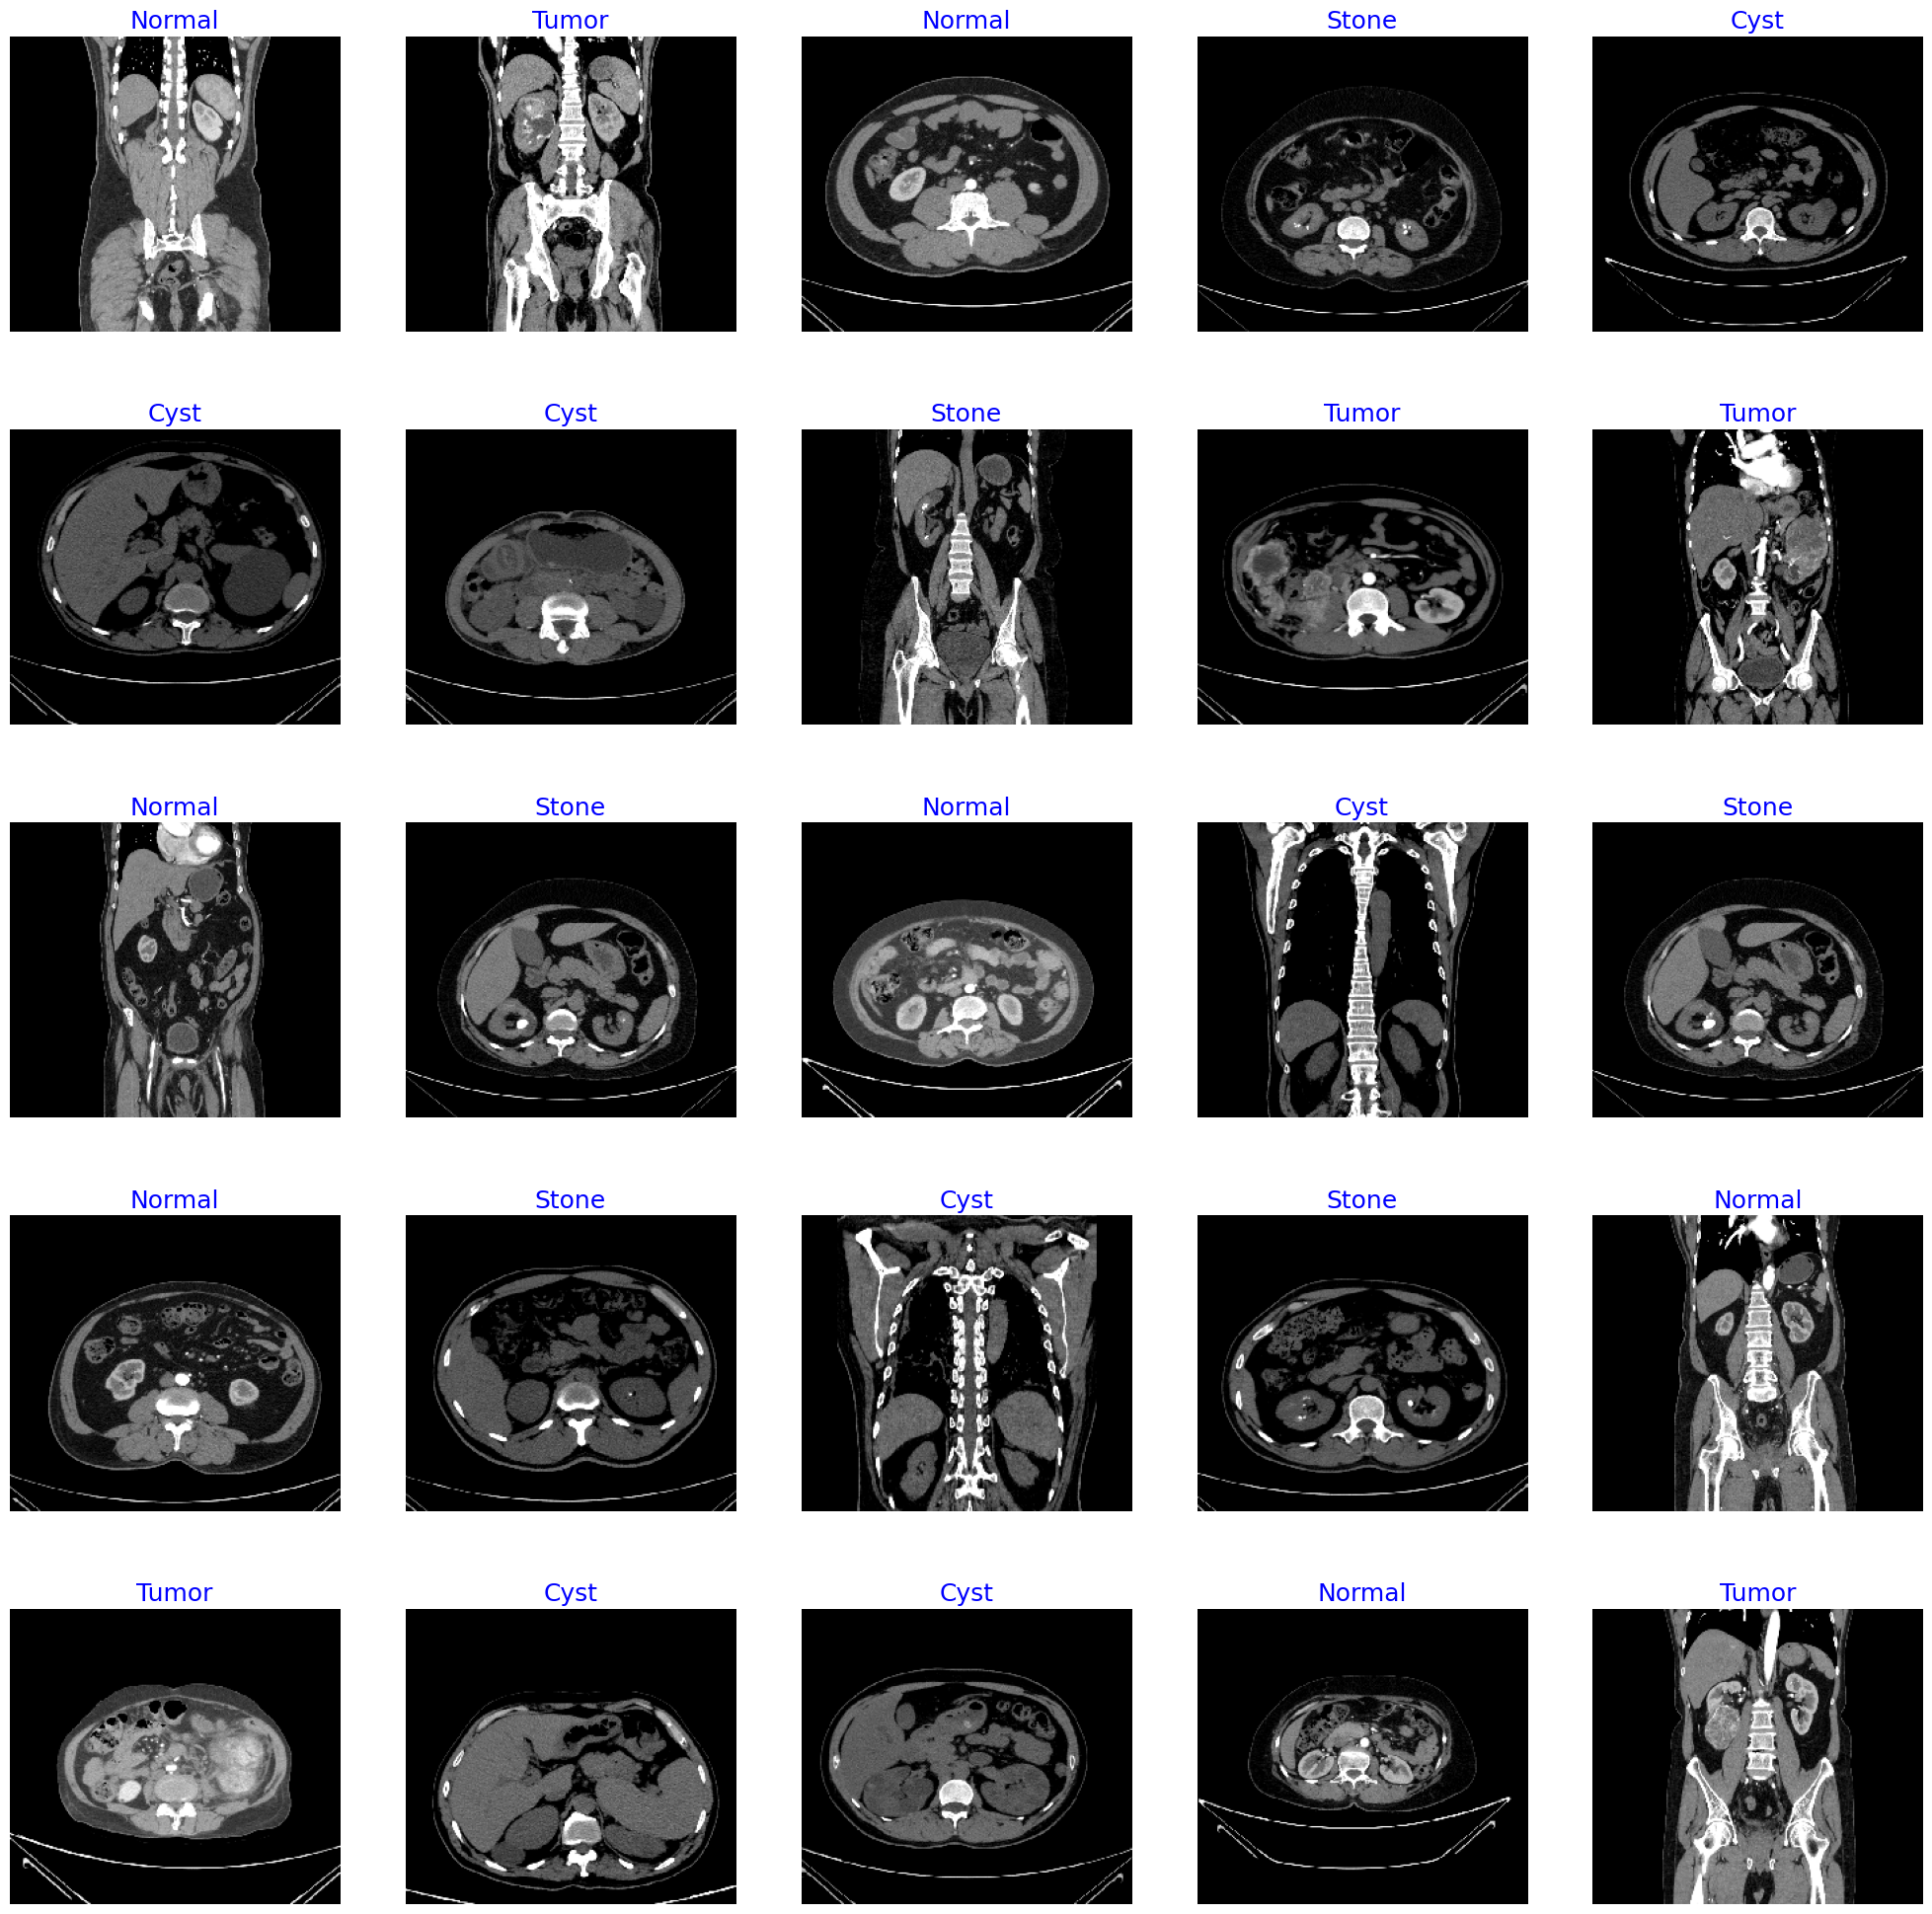

In [15]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )


Function To calculate F1 Matrix

In [16]:
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val



In [17]:
## Model Using Transfer Learnign Effecient net 
def make_model(img_size, lr, mod_num=3):  
    img_shape=(img_size[0], img_size[1], 3)
    if mod_num == 0:
        base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B0 model'
    elif mod_num == 3:
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B3 model'
    elif mod_num == 5:
        base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B5 model'
        
    else:
        base_model=tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B7 model'   
   
    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy', F1_score]) 
    msg=msg + f' with initial learning rate set to {lr}'
    print_in_color(msg)
    return model

lr=.001
model=make_model(img_size, lr) # using B3 model by default


Created EfficientNet B3 model with initial learning rate set to 0.001



In [18]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.4): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor
        
    def get_list(self): # define a function to return the list of % validation change
        return self.plist, self.alist
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            msg =f'Training will proceed until epoch {ask_epoch} then you will be asked to' 
            print_in_color(msg )
            msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print_in_color(msg)
            if self.dwell:
                msg='learning rate will be automatically adjusted during training'
                print_in_color(msg, (0,255,0))
        self.start_time= time.time() # set the time at which training started
       
    def on_train_end(self, logs=None):   # runs at the end of training  
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, (0,255,255))
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        if epoch >0:
            deltav = self.lowest_vloss- vloss 
            pimprov=(deltav/self.lowest_vloss) * 100 
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov=0.0 
            aimprov=0.0
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1            
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print_in_color(msg, (0,255,0)) # green foreground
        else: # validation loss increased
            pimprov=abs(pimprov)
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print_in_color(msg, (255,255,0)) # yellow foreground
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print_in_color(msg) # cyan foreground
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                self.model.set_weights(self.best_weights) # set the weights of the model to the best weights      
                
        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                msg='press enter to continue or enter a comment  below '
                print_in_color(msg)
                comment=input(' ')
                if comment !='':
                    print_in_color(comment, (155,245,66))
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print_in_color(msg) # cyan foreground
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print_in_color(msg) # cyan foreground
                        if self.dwell==False:
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                            msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            print_in_color(msg) # cyan foreground
                            ans=input(' ')
                            if ans =='':
                                msg=f'keeping current LR of {lr:7.5f}'
                                print_in_color(msg) # cyan foreground
                            else:
                                new_lr=float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                                msg=f' changing LR to {ans}'
                                print_in_color(msg) # cyan foreground



In [19]:
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

In [20]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
                 shuffle=False,  initial_epoch=0)

Training will proceed until epoch 5 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/40
67/67 [==============================] - ETA: 0s - loss: 7.7724 - accuracy: 0.7780 - F1_score: 0.7746
 validation loss of  7.2377 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

67/67 [==============================] - 76s 875ms/step - loss: 7.7724 - accuracy: 0.7780 - F1_score: 0.7746 - val_loss: 7.2377 - val_accuracy: 0.7836 - val_F1_score: 0.7803
Epoch 2/40
67/67 [==============================] - ETA: 0s - loss: 5.9533 - accuracy: 0.9470 - F1_score: 0.9469
 validation loss of  5.7819 is 20.1143 % below lowest loss, saving weights from epoch 2   as best weights

67/67 [==============================] - 45s 675ms/step - loss: 5.9533 - accuracy: 0.9470 - F1_score: 0.9469 - val_loss: 5.7819 - val_accuracy: 0.7890 - val_F1_sco

  5


5


 Enter H to end training or  an integer for the number of additional epochs to run then ask again



 5


you entered 5 Training will continue to epoch 10

67/67 [==============================] - 100s 2s/step - loss: 3.3343 - accuracy: 0.9905 - F1_score: 0.9899 - val_loss: 3.1946 - val_accuracy: 0.9566 - val_F1_score: 0.9503
Epoch 6/40
67/67 [==============================] - ETA: 0s - loss: 2.8076 - accuracy: 0.9935 - F1_score: 0.9933
 validation loss of  2.6461 is 17.1704 % below lowest loss, saving weights from epoch 6   as best weights

67/67 [==============================] - 45s 674ms/step - loss: 2.8076 - accuracy: 0.9935 - F1_score: 0.9933 - val_loss: 2.6461 - val_accuracy: 0.9711 - val_F1_score: 0.9701
Epoch 7/40
67/67 [==============================] - ETA: 0s - loss: 2.3669 - accuracy: 0.9955 - F1_score: 0.9954
 validation loss of  2.1949 is 17.0503 % below lowest loss, saving weights from epoch 7   as best weights

67/67 [==============================] - 46s 684ms/step - loss: 2.3669 - accuracy: 0.9955 - F1_score: 0.9954 - val_loss: 2.1949 - val_accuracy: 0.9791 - val_F1_scor

  5


5


 Enter H to end training or  an integer for the number of additional epochs to run then ask again



 5


you entered 5 Training will continue to epoch 15

67/67 [==============================] - 115s 2s/step - loss: 1.4070 - accuracy: 0.9945 - F1_score: 0.9942 - val_loss: 1.3045 - val_accuracy: 0.9888 - val_F1_score: 0.9874
Epoch 11/40
67/67 [==============================] - ETA: 0s - loss: 1.1923 - accuracy: 0.9965 - F1_score: 0.9967
 validation loss of  1.0756 is 17.5438 % below lowest loss, saving weights from epoch 11  as best weights

67/67 [==============================] - 45s 674ms/step - loss: 1.1923 - accuracy: 0.9965 - F1_score: 0.9967 - val_loss: 1.0756 - val_accuracy: 0.9936 - val_F1_score: 0.9942
Epoch 12/40
67/67 [==============================] - ETA: 0s - loss: 1.0007 - accuracy: 0.9990 - F1_score: 0.9982
 validation loss of  0.8963 is 16.6732 % below lowest loss, saving weights from epoch 12  as best weights

67/67 [==============================] - 45s 670ms/step - loss: 1.0007 - accuracy: 0.9990 - F1_score: 0.9982 - val_loss: 0.8963 - val_accuracy: 0.9963 - val_F1_sc

  H


H


 Enter H to end training or  an integer for the number of additional epochs to run then ask again



 H


you entered H,  Training halted on epoch 15 due to user input


67/67 [==============================] - 181s 3s/step - loss: 0.6101 - accuracy: 1.0000 - F1_score: 0.9995 - val_loss: 0.5478 - val_accuracy: 0.9957 - val_F1_score: 0.9965
loading model with weights from epoch 15

training elapsed time was 0.0 hours, 16.0 minutes, 46.89 seconds)



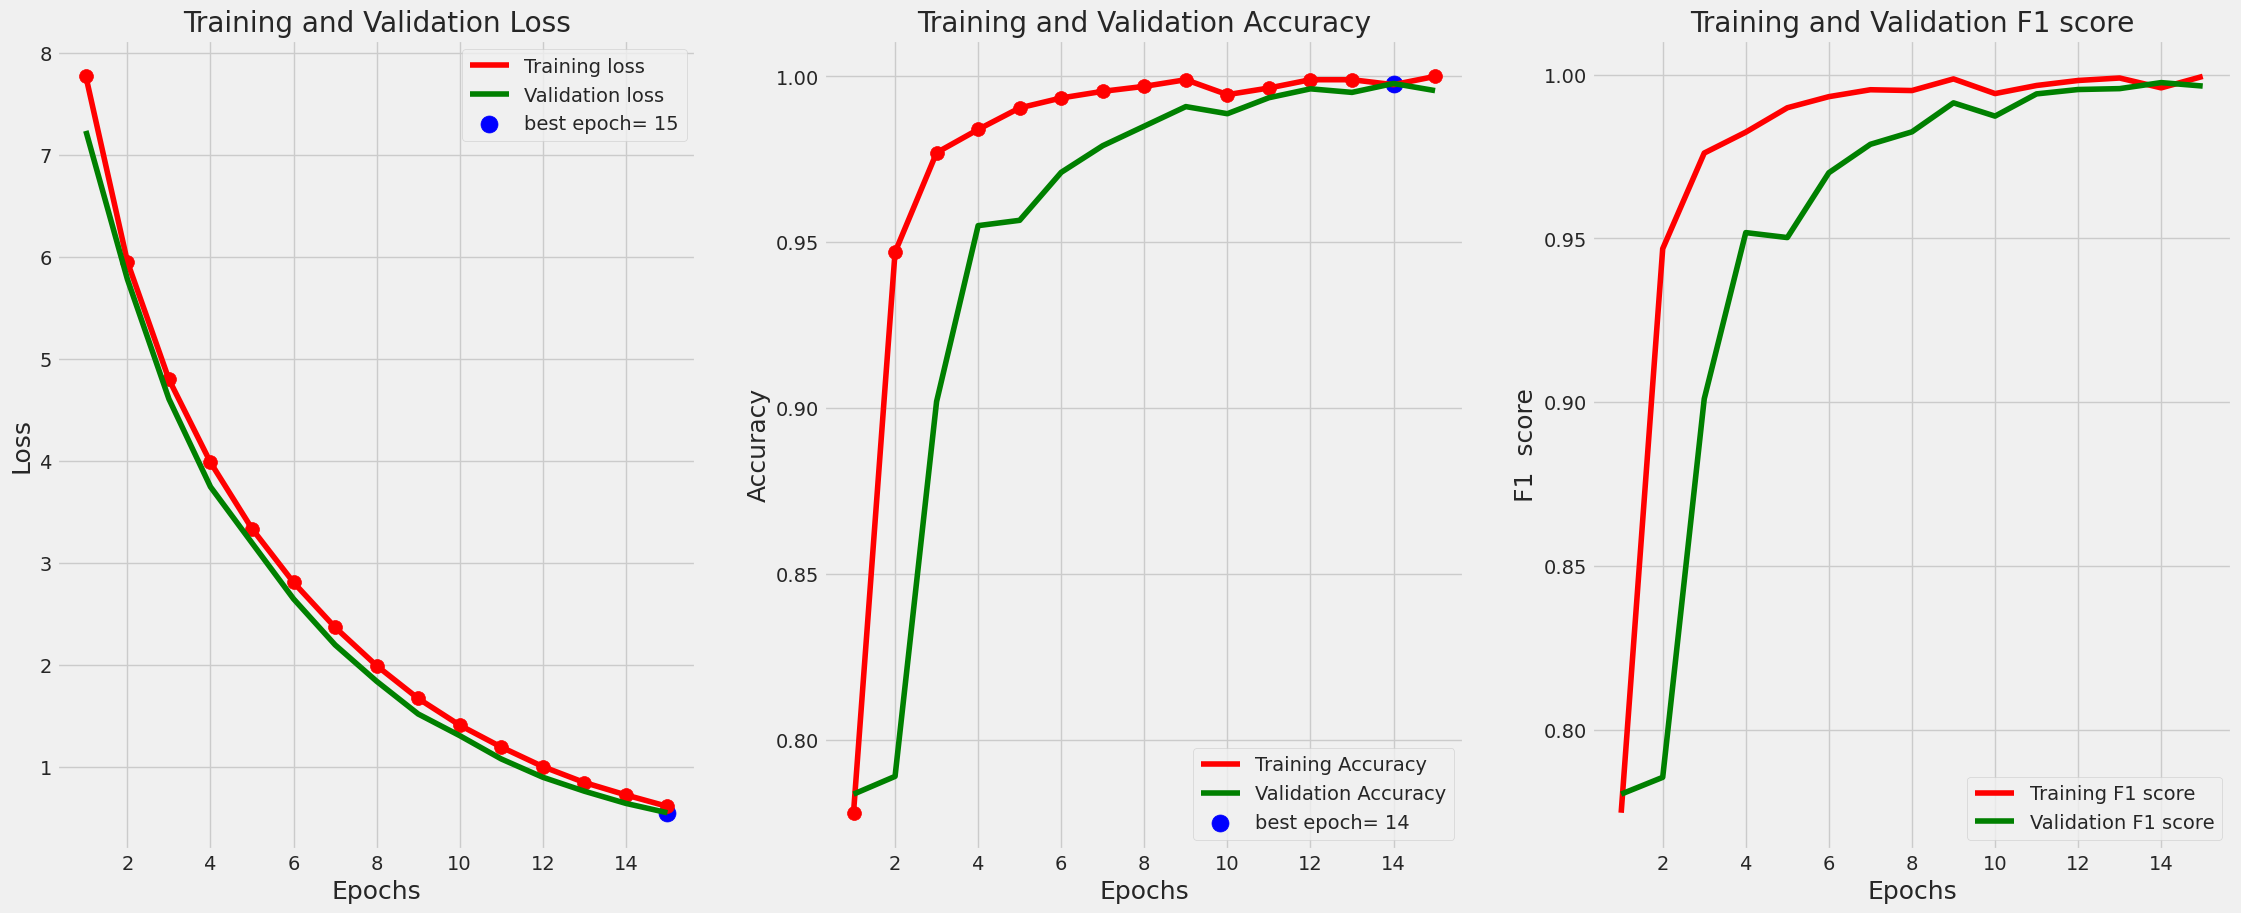

In [26]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tf1=tr_data.history['F1_score']
    vf1=tr_data.history['val_F1_score']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=3, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')    
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    index_tf1=np.argmax(tf1)#  this is the epoch with the highest training F1 score
    tf1max=tf1[index_tf1]
    index_vf1=np.argmax(vf1)# thisiis the epoch with the highest validation F1 score
    vf1max=vf1[index_vf1]
    #axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)
    #axes[2].scatter(Epochs, tf1max, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1  score', fontsize=18)
    axes[2].legend()
    
    plt.tight_layout    
    plt.show()
    return index_loss
    
loss_index=tr_plot(history,0)

Make Predictions on the test set</a>

In [22]:
def predictor(test_gen):    
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]
            error_list.append(file)
            error_class=classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, error_pred_list, f1score



1867/1867 [==============================] - 39s 20ms/step
there were 10 errors in 1867 tests for an accuracy of  99.46



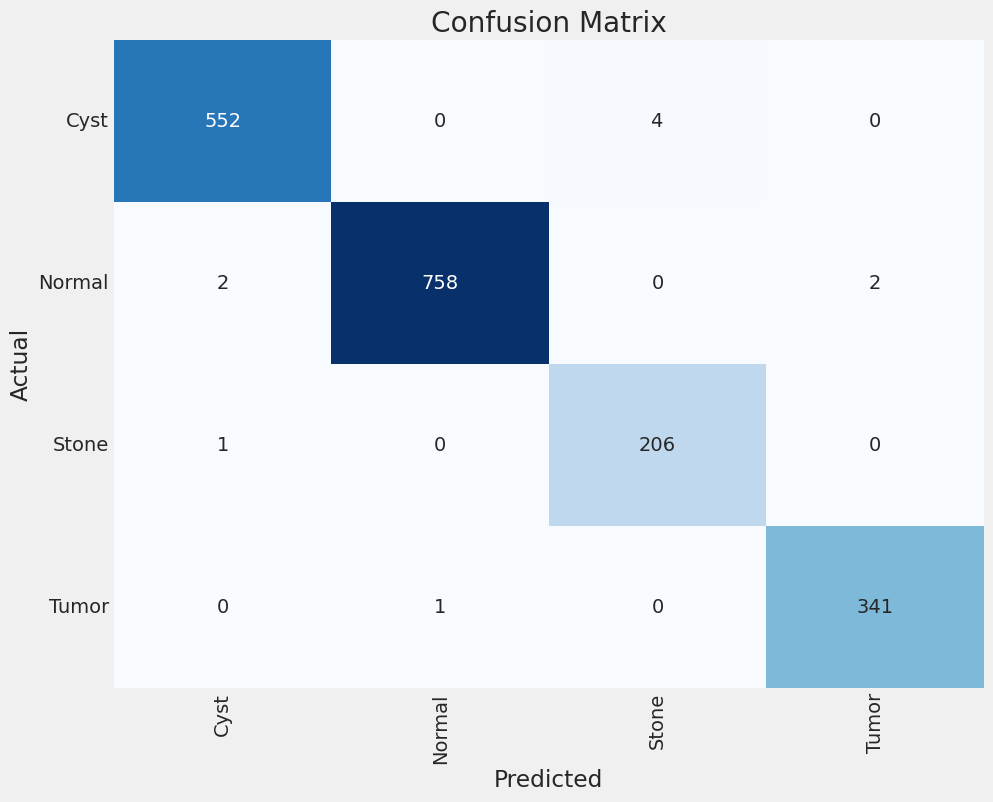

Classification Report:
----------------------
               precision    recall  f1-score   support

        Cyst     0.9946    0.9928    0.9937       556
      Normal     0.9987    0.9948    0.9967       762
       Stone     0.9810    0.9952    0.9880       207
       Tumor     0.9942    0.9971    0.9956       342

    accuracy                         0.9946      1867
   macro avg     0.9921    0.9950    0.9935      1867
weighted avg     0.9947    0.9946    0.9947      1867



In [23]:
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)

In [27]:
# Image Mis Predicted are 
def print_errors(error_list):
    if len(error_list) == 0:
        print_in_color('There were no errors in predicting the test set')
    else:
        if len(error_list)<50:
            print ('Below is a list of test files that were miss classified \n')
            print ('{0:^30s}{1:^30s}'.format('Test File', ' Predicted as'))            
            for i in range(len(error_list)):
                fpath=error_list[i]        
                split=fpath.split('/')        
                f=split[4]+ '-' + split[5]
                print(f'{f:^30s}{error_pred_list[i]:^30s}')

In [28]:
print_errors(error_list)


Below is a list of test files that were miss classified 

          Test File                    Predicted as         
CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone-Cyst            Stone             
CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone-Cyst            Stone             
CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone-Cyst            Stone             
CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone-Tumor            Normal            
CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone-Normal            Tumor             
CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone-Stone             Cyst             
CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone-Cyst            Stone             
CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone-Normal             Cyst             
CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone-Normal             Cyst             
CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone-Normal            Tumor             


In [32]:
from tensorflow.keras.models import load_model


In [35]:
model.save('Final.h5')
## F1_score

In [53]:
model=load_model("/kaggle/working/Final.h5",custom_objects={"F1_score":f1_score})


In [54]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 250, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 250, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 250, 3)  0           ['normalization[0][0]']      

In [ ]:
model.predict(img)

In [55]:
!pip install Image

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 46.4 MB/s eta 0:00:0000:0100:01
  Created wheel for Image: filename=image-1.5.33-py2.py3-none-any.whl size=19494 sha256=026e5c2b13e830a31c22e45a95c662a8511d361969aa66e8b5e4c4fcef67b699
  Stored in directory: /root/.cache/pip/wheels/23/29/74/b2ac5172832c36fb4cb4126f66765568099d9ddaf8a8613502
Successfully built Image


In [64]:
from PIL import Image
img = Image.open("/kaggle/input/images/images (3).jfif")
new_image = img.resize((240, 250))

Input image shape: (1, 224, 250, 3)


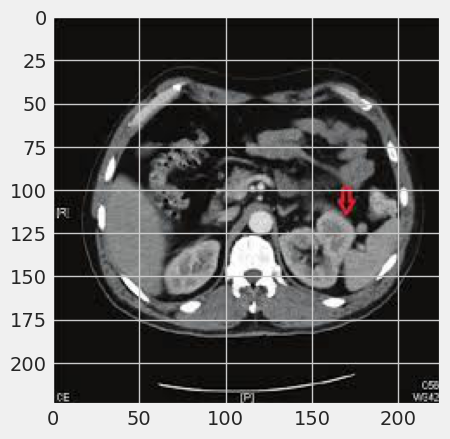

In [100]:
import cv2
import numpy as np
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input


img_path = '/kaggle/input/images/images (3).jfif'

img = cv2.imread(img_path)
img = cv2.resize(img, (250, 224))

x = np.expand_dims(img, axis=0)
x = preprocess_input(x)

print('Input image shape:', x.shape)

my_image = imread(img_path)
imshow(my_image)

In [101]:
preds=model.predict(x)
print("predicted class: ",preds ) 
print 

1/1 [==============================] - 2s 2s/step
predicted class:  [[0. 0. 0. 1.]]


In [102]:
classes

array(['Tumor', 'Cyst', 'Normal', 'Stone'], dtype=object)

In [105]:
prediction = model.predict(x)

#convert the prediction to a class label
predicted_class = np.argmax(prediction, axis=1)
print("The predicted class of the image is: ", predicted_class)
print("The predicted class is ",classes[predicted_class])

1/1 [==============================] - 0s 31ms/step
The predicted class of the image is:  [3]
The predicted class is  ['Stone']


In [126]:
def Pred(img_path):
    from tensorflow.keras.applications.imagenet_utils import preprocess_input

    img = cv2.imread(img_path)
    img = cv2.resize(img, (250, 224))
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x)

    my_image = imread(img_path)
    prediction = model.predict(x)

    #convert the prediction to a class label
    classes=['Tumor', 'Cyst', 'Normal', 'Stone']
    predicted_class = classes[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)
    
    return predicted_class, confidence

In [127]:
Pred("/kaggle/input/images-new/MRI-of-the-cyst-in-left-kidney-MRI-Magnetic-resonance-imaging.png")

1/1 [==============================] - 0s 30ms/step


('Cyst', 100.0)

In [7]:
print(tf.__version__)

2.9.1
